In [1]:

# This allows us to read the cities.json file. The format of the file
# is 'Javascript Object Notation' (JSON). It's a way of representing
# essential data structures, like lists and key-value pairs.

import json

# Our data will be in this format:
#    {
#        "city": "Beloit", 
#        "growth_from_2000_to_2013": "2.9%", 
#        "latitude": 42.5083482, 
#        "longitude": -89.03177649999999, 
#        "population": "36888", 
#        "rank": "999", 
#        "state": "Wisconsin"
#    },

cities_dataset = json.load(open('cities.json'))


In [2]:

def manhattan_distance(starting_point, destination):
    """
    This is a function that tells you basically, 'If my coordinates were city blocks, and
    I couldn't walk through the middle of the block, how far would I have to walk to get from
    a to b, using city streets?
    """
    distance = 0
    n_dimensions = len(starting_point)
    for dimension in range(n_dimensions):
        # Could be streets, could be avenues, could be anything!
        distance_at_dimension = abs(starting_point[dimension] - destination[dimension])
        distance += distance_at_dimension
    return distance


In [3]:
# Let's compare cities!

# First, we know that cities close together have some things in common.
# It's fair to say that Chicago and Minneapolis are 'similar' in some
# important ways. Let's see what computing the overlap of latitudes and
# longitudes looks like.

# We're going to store the cities in a dictionary
# The key will be the city name
# The value will be the coordinates of the city. Latitude and longitude
# are just a geographic, 2 dimensional vector:

lonlat = {}

for city in cities_dataset:
    lonlat[city['city']] = [city['longitude'], city['latitude']]

In [5]:
# Woah! That's a lot of cities! Let's simplify with ones with a bigger population:
big_cities = {}
for city in cities_dataset:
    if int(city['population']) > 100000:
        big_cities[city['city']] = [city['longitude'], city['latitude']]

In [23]:
# Now, let's make a function that finds the nearest city to each other city,
# using the oversimplified-but-fine approximation of the Manhattan distance.
# We'll also take a little shortcut, in that extremely close cities are often
# really more of the same city (Houston-Pearland, San Francisco-Daly City). For
# cities to even be distinct at all geographically, let's say they have to be
# roughly 1,000 blocks apart (0.001 degree longitude is about a block in North
# America, appropriate for our Manhattan distance metric ;)
def approximate_nearest_city(city_name, cities, minimum_distance = 1.0):
    coordinates = cities[city_name]
    # So far, we have nothing 'nearest', so start our search with a large value:
    nearest = 1000
    nearest_name = None
    for other_city, other_coordinates in cities.items():
        # calculate the distance between the two cities
        distance = manhattan_distance(coordinates, other_coordinates)
        # if the distance is less than the current nearest, update the nearest
        # unless the distance is so small we'd really be comparing the same city
        # to itself
        if distance < nearest and distance > minimum_distance:
            nearest = distance
            nearest_name = other_city

    # return the nearest city
    return nearest_name, nearest


In [44]:
# Now, let's test it out. Also, we are going to see how long it takes to find
# the nearest city to each other city:
import time
starting_time = time.time()
for city in list(big_cities.keys())[:5]:
    nearest, how_far = approximate_nearest_city(city, big_cities)
    print(f'the nearest city to {city} is {nearest} ({how_far})')

ending_time = time.time()

print('It took', ending_time - starting_time, 'seconds to find the nearest city to each other city.')


the nearest city to New York is Bridgeport (1.2845287000000098)
the nearest city to Los Angeles is San Bernardino (1.010030399999998)
the nearest city to Chicago is Milwaukee (1.437464300000002)
the nearest city to Houston is Beaumont (1.5629939000000057)
the nearest city to Philadelphia is Elizabeth (1.665928600000008)
It took 0.0031671524047851562 seconds to find the nearest city to each other city.


In [25]:
# So this kind of works, but we want something a little deeper. More 'similarity' than just
# 'nearness'. Let's try to find the most similar city to each other city, using additional features.
# Intuitively, nearby cities do share a lot in common. But also, big cities have some of that bigness
# in common, apart from geography. Let's see what we can do with that.

# Now, let's start thinking of our cities list as a matrix. Each row is a city, and each column is a feature.
big_cities_list = [city for city in cities_dataset if int(city['population']) > 100000]
names = [city['city'] for city in big_cities_list]
longitudes = [city['longitude'] for city in big_cities_list]
latitudes = [city['latitude'] for city in big_cities_list]
populations = [float(city['population']) for city in big_cities_list]
growth_rates = [float(city['growth_from_2000_to_2013'].replace('%', '')) for city in big_cities_list]


In [26]:
# So far, so good, but how do we compare the number of people in one city to the degrees latitude of another?
# Answer: you don't! Intuitively, we know that longitude, the Eastness-Westness of a city, does mean something
# to us. Seattle has some things in common with San Francisco much further South. And likewise Phoenix to
# Jacksonville in terms of latitude -- there's a real "sunbelt" effect uniting these distant cities. So we want
# to keep all those features, but not over-emphasize any in particular. Again, we're designing our features here.
# And BTW, since we're designing features, let's throw in one more: the market share of pickup trucks in the state!
# Because why not?! Also lets us practice reading CSV files.

# our format will be:
# Connecticut,9.4%
# New Jersey,7.8%
# ...

import csv
share = csv.DictReader(open('pickup-trucks.csv'), delimiter = ',', fieldnames=['state', 'market_share'])
state_truck_share = {}
for state in share:
    state_name = state['state']
    market_share = float(state['market_share'].replace('%', ''))
    state_truck_share[state_name] = market_share

pickup_market_share = [state_truck_share[city['state']] for city in big_cities_list]


In [45]:
pickup_market_share[:5]

[11.4, 10.3, 10.8, 19.0, 13.6]

In [28]:
# Back to our matrix! We definitely won't be comparing longitudes to pickups! So let's rescale all our features

# We'll use this common function:

def rescale(vector, range = (-0.5, 0.5)):
    """
    This function takes a vector of numbers, and rescales it to be between
    the range specified. The default range is -0.5 to 0.5, which is where
    floating point numbers are most accurate.
    """
    # find the minimum and maximum values in the vector
    min_value = min(vector)
    max_value = max(vector)
    # find the range of the vector
    vector_range = max_value - min_value
    # find the range we want to rescale to
    target_range = range[1] - range[0]
    # rescale the vector
    rescaled = [range[0] + (x - min_value) * target_range / vector_range for x in vector]
    return rescaled

# Now, let's rescale all our features:
rescaled_longitudes = rescale(longitudes)
rescaled_latitudes = rescale(latitudes)
rescaled_populations = rescale(populations)
rescaled_growth_rates = rescale(growth_rates)
rescaled_pickup_market_share = rescale(pickup_market_share)

# Now, let's put all our features together into a matrix:
import numpy as np

matrix = np.array([rescaled_longitudes, rescaled_latitudes, rescaled_populations,
    rescaled_growth_rates, rescaled_pickup_market_share])

In [29]:
# Now, let's transpose the matrix, so that each row is a city, and each column is a feature:

matrix = matrix.T

# Now, let's take a couple of approaches. Here we normalize so that each city's vector has length 1:
normalized_matrix = matrix / np.linalg.norm(matrix, axis = 1).reshape(-1, 1)

# Working with the normalized matrix is really like "how much are these two vectors pointing in the same direction?"
# Because the magnitude of each row is 1, we can just take the dot product of each row with every other row. This
# is the same as matrix multiplication, but we're multiplying a matrix by its transpose. So we can use the @ operator

similarities = normalized_matrix @ normalized_matrix.T

# Now, arrange the results such that the most similar city is at the top of the list (which will be itself), and
# the least similar city is at the bottom of the list (which will be the city furthest away in terms of our combined
# features):

# Axis = 1 means we're sorting each row, and -1 means we're sorting in descending order
# Argsort returns the indices of the sorted array -- where you would have to put stuff so that it appears in order
rankings = np.argsort(-similarities, axis = 1)

In [46]:
# Now, let's print out the most similar city to each other city:

def show_rankings(rankings, names, n=5, preamble=''):
    for index, name in enumerate(names):
        if index > 5: # Let's just print the first few
            return
        top_n = rankings[index][1:1+n]
        near = [names[i] for i in top_n]
        far = [names[i] for i in rankings[index][-n:]]
        print(preamble, name, 'is most similar to', ', '.join(near), 'and least similar to', ', '.join(far))

show_rankings(rankings, names)

 New York is most similar to Chicago, Los Angeles, Philadelphia, Boston, Baltimore and least similar to Billings, Boise City, Frisco, Surprise, Anchorage
 Los Angeles is most similar to San Diego, San Jose, Phoenix, San Francisco, Long Beach and least similar to Sioux Falls, Anchorage, Surprise, Billings, Frisco
 Chicago is most similar to Baltimore, Philadelphia, Newark, Paterson, Jersey City and least similar to Boise City, Billings, Anchorage, Surprise, Frisco
 Houston is most similar to San Antonio, Dallas, Austin, Mobile, New Orleans and least similar to Billings, New York, Frisco, Surprise, Anchorage
 Philadelphia is most similar to Boston, Baltimore, Yonkers, Washington, Virginia Beach and least similar to Billings, Honolulu, Frisco, Surprise, Anchorage
 Phoenix is most similar to Tucson, Mesa, Glendale, Tempe, Santa Ana and least similar to Billings, Surprise, New York, Anchorage, Frisco


In [31]:
# There are some interesting results here. For example, this record:

"""{'city': 'Frisco',
 'growth_from_2000_to_2013': '287.7%',
 'latitude': 33.1506744,
 'longitude': -96.82361159999999,
 'population': '136791',
 'rank': '186',
 'state': 'Texas'}"""

# Frisco, Texas has such an astounding growth rate that it really is very unlike anywhere on the list!

In [194]:
# So now we have some intuition about feature vectors. A "feature" is just a value like "population growth rate",
# or latitude, or market share of pickup trucks. We've got a few manually assembled features like that.

# Deep learning is capable of finding those features for us. We tell the model, find us the latitude, and frombitude,
# and glouflitude... for hundreds of dimensions. Find whatever we need to do our task.

# So let's try some deep learning. Instead of making up a feature vector for each city, we let loose
# a neural network, with the broad instructions of: "find the 512 dimensions (*-tudes!) that best capture
# the semantic essence of every word and image on the internet". The below model learns which images go
# with which captions -- we'll use it here to do the caption part, independent of any images. We need to
# get our data into a format that a neural network can understand -- for this model that just means English!

import sentence_transformers
model = sentence_transformers.SentenceTransformer('clip-ViT-B-32').to('cuda')

def embed_row(row):
    # Little bit of practical engineering here: language models are not exceptionally
    # good at dealing with numbers. And the really big ones don't entirely need to be!
    # So let's just use the proper name for the city an state, and see what happens:
    sentence = f"""{row.get('city')}, {row['state']}"""
    embedding = model.encode(sentence)
    return embedding / np.linalg.norm(embedding, keepdims=True)


In [195]:
# Now, let's embed all our cities:
embeddings = np.array([embed_row(row) for row in big_cities_list])
# and normalize the result:
embeddings = embeddings / np.linalg.norm(embeddings, axis = 1).reshape(-1, 1)

In [196]:
embeddings[4].shape
# These are just normalized vectors, same as the ones we made up with latitude, trucks, etc:

(512,)

In [197]:
# Getting pretty close now. 

In [198]:
# Now, let's see how similar these embeddings are to each other:
embeddings_distances = embeddings @ embeddings.T
embeddings_rankings = np.argsort(-embeddings_distances, axis = 1)


def top_n_ranking(rankings, index, n=5):
    top_n = rankings[index][1:1+n]
    near = [names[i] for i in top_n]
    far = [names[i] for i in rankings[index][-n:]]
    return near, far


def show_ranking(rankings, index, preamble=''):
    near, far = top_n_ranking(rankings, index)
    print(preamble, 'is most similar to:', ', '.join(near))
    print(preamble, 'is least similar to:', ', '.join(far))


def compare_models(city_name, state_name):
    # Almost 10 of America's top 300 cities share the same name. So we need to be more specific.
    idx = 0
    found = False
    for row in big_cities_list:
        if row['city'] == city_name and row['state'] == state_name:
            found = True
            break
        idx += 1
    if not found:
        print("Couldn't find", city_name, 'in', state_name)
        return
    print('Now find the most similar city to', city_name, 'in each model:')
    show_ranking(rankings, idx, preamble=f'With our manually created basic features, {city_name}, {state_name} ')
    show_ranking(embeddings_rankings, idx, preamble=f'With our deep learning model, {city_name}, {state_name} ')
    

In [200]:
compare_models('San Diego', 'California')


Now find the most similar city to San Diego in each model:
With our manually created basic features, San Diego, California  is most similar to: Long Beach, Santa Ana, Anaheim, Huntington Beach, Oceanside
With our manually created basic features, San Diego, California  is least similar to: Surprise, New York, Billings, Anchorage, Frisco
With our deep learning model, San Diego, California  is most similar to: Santa Ana, San Jose, San Mateo, Oceanside, Costa Mesa
With our deep learning model, San Diego, California  is least similar to: Bridgeport, New Haven, Raleigh, Waterbury, Henderson


In [201]:
compare_models('Anchorage', 'Alaska')


Now find the most similar city to Anchorage in each model:
With our manually created basic features, Anchorage, Alaska  is most similar to: Boise City, Billings, Portland, Everett, Gresham
With our manually created basic features, Anchorage, Alaska  is least similar to: Surprise, Miramar, Port St. Lucie, Frisco, New York
With our deep learning model, Anchorage, Alaska  is most similar to: Everett, Tacoma, Vancouver, Kent, Bellevue
With our deep learning model, Anchorage, Alaska  is least similar to: Stamford, New Haven, Raleigh, Waterbury, Henderson


In [203]:
compare_models('Dallas', 'Texas')

Now find the most similar city to Dallas in each model:
With our manually created basic features, Dallas, Texas  is most similar to: Mobile, Beaumont, Arlington, Garland, Birmingham
With our manually created basic features, Dallas, Texas  is least similar to: Billings, New York, Anchorage, Frisco, Surprise
With our deep learning model, Dallas, Texas  is most similar to: Houston, Fort Worth, Irving, Richardson, Austin
With our deep learning model, Dallas, Texas  is least similar to: Raleigh, Charleston, New Haven, Waterbury, Henderson


In [204]:
compare_models('San Francisco', 'California')

Now find the most similar city to San Francisco in each model:
With our manually created basic features, San Francisco, California  is most similar to: San Jose, Oakland, Sacramento, Daly City, Fremont
With our manually created basic features, San Francisco, California  is least similar to: Anchorage, Surprise, Billings, New York, Frisco
With our deep learning model, San Francisco, California  is most similar to: Santa Clara, Los Angeles, Seattle, Oakland, Santa Ana
With our deep learning model, San Francisco, California  is least similar to: Peoria, New Haven, Raleigh, Henderson, Waterbury


In [53]:
# BONUS POINTS!

In [208]:
# If a machine learning researcher was stranded on a desert island in 2009, and came back
# to civilization today, this would be really hard to explain to him or her! Give yourself
# time to think about it!

from PIL import Image

def city_image_neighbor(image_path):
    image = Image.open(image_path)
    embedding = model.encode(image)
    embedding /= np.linalg.norm(embedding, keepdims=True)
    distances = embedding @ embeddings.T
    top_5 = np.argsort(-distances)[:5]
    return [big_cities_list[i] for i in top_5]

In [209]:
matches = city_image_neighbor('cowboy.jpg')

The following cities are most similar to this image of a cowboy:  Amarillo, Texas; Laredo, Texas; Frisco, Texas; Midland, Texas; Fort Worth, Texas


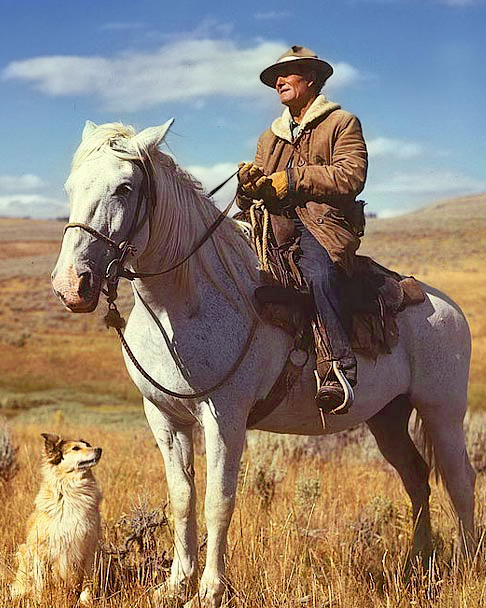

In [210]:
print("The following cities are most similar to this image of a cowboy: ",
      '; '.join([match.get('city') + ', ' + match.get('state') for match in matches]))
im = Image.open('cowboy.jpg')
display(im)


In [211]:
matches2 = city_image_neighbor('new-york.jpg')

The following cities are most similar to this image of Central Park, NYC:  New York, New York; Jersey City, New Jersey; Chicago, Illinois; Washington, District of Columbia; Boston, Massachusetts


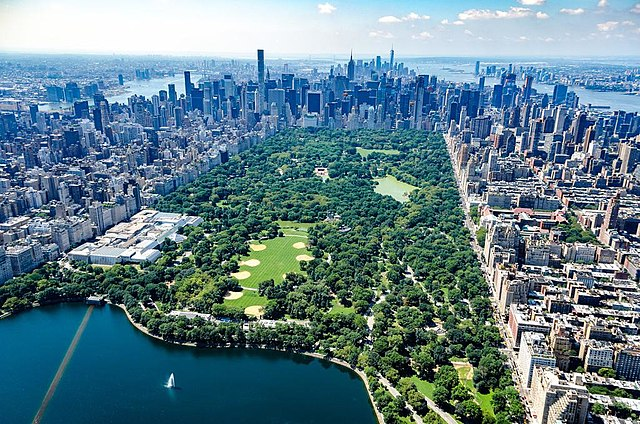

In [212]:
print("The following cities are most similar to this image of Central Park, NYC: ",
      '; '.join([match.get('city') + ', ' + match.get('state') for match in matches2]))
im = Image.open('new-york.jpg')
display(im)

The following cities are most similar to this image of a container port:  Newport News, Virginia; Norfolk, Virginia; Richmond, California; Port St. Lucie, Florida; Corpus Christi, Texas


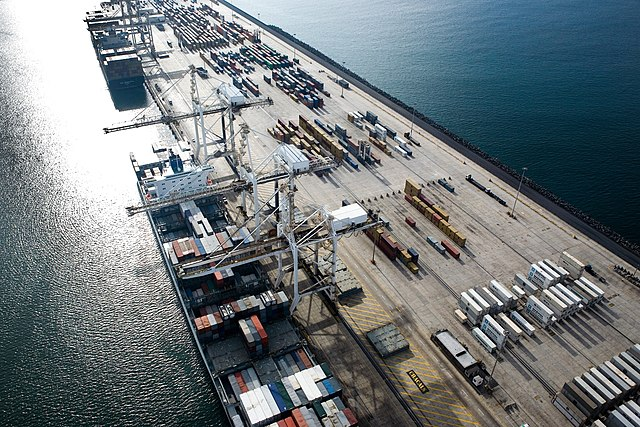

In [213]:
matches_port = city_image_neighbor('Container_port.jpg')

print("The following cities are most similar to this image of a container port: ",
      '; '.join([match.get('city') + ', ' + match.get('state') for match in matches_port]))
im = Image.open('Container_port.jpg')
display(im)

In [214]:
def city_phrase_neighbor(phrase):
    embedding = model.encode(phrase)
    embedding /= np.linalg.norm(embedding, keepdims=True)
    distances = embedding @ embeddings.T
    top_5 = np.argsort(-distances)[:5]
    return [big_cities_list[i] for i in top_5]


In [215]:
matches3 = city_phrase_neighbor("Mississippi River")

In [216]:
print("The following cities are most similar to the phrase 'Mississippi River': ",
      '; '.join([match.get('city') + ', ' + match.get('state') for match in matches3]))


The following cities are most similar to the phrase 'Mississippi River':  Jackson, Mississippi; Memphis, Tennessee; Rochester, Minnesota; Shreveport, Louisiana; Tyler, Texas


In [217]:
matches4 = city_phrase_neighbor("Thriving economy full of opportunity")

In [218]:
print("The following cities are most similar to the phrase 'Thriving economy full of opportunity': ",
      '; '.join([match.get('city') + ', ' + match.get('state') for match in matches4]))

The following cities are most similar to the phrase 'Thriving economy full of opportunity':  New York, New York; Frisco, Texas; Norwalk, California; Irving, Texas; Carrollton, Texas


In [221]:
matches5 = city_phrase_neighbor("Midwest")

In [223]:
print("The following cities are most similar to the phrase 'Midwest': ",
      '; '.join([match.get('city') + ', ' + match.get('state') for match in matches5]))

The following cities are most similar to the phrase 'Midwest':  Davenport, Iowa; Fort Wayne, Indiana; South Bend, Indiana; Evansville, Indiana; Frisco, Texas
